In [1]:
import xarray as xr
import pandas as pd
import pop_tools
import numpy as np
import cftime
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from datetime import datetime
import glob
import flox
import scipy.stats

# Reading in SAU catch data

In [2]:
df = pd.read_csv('data/SAUP_LME_Catch_annual_newF.csv')

true_catch = df.set_index(["Year", "LMEID"]).to_xarray()

true_catch

### units on catch variables are g wet weight m-2 per year

<xarray.Dataset>
Dimensions:  (Year: 61, LMEID: 65)
Coordinates:
  * Year     (Year) int64 1950 1951 1952 1953 1954 ... 2006 2007 2008 2009 2010
  * LMEID    (LMEID) int64 1 2 3 4 5 6 7 8 9 10 ... 57 58 59 60 61 62 63 65 66
Data variables:
    FwCatch  (Year, LMEID) float64 26.91 154.4 5.209e+03 0.0 ... 63.51 202.2 0.0
    PwCatch  (Year, LMEID) float64 5.118e+04 3.992e+05 ... 4.185e+04 0.008851
    DwCatch  (Year, LMEID) float64 2.473e+04 2.227e+05 ... 8.225e+05 9.241

In [3]:
lme_metadata_csv = pd.read_csv('data/LME_metadata.csv', thousands=',')

lme_metadata = lme_metadata_csv.set_index(["LME Number"]).to_xarray().rename(name_dict={"LME Number" : "LMEID"})

lme_metadata

<xarray.Dataset>
Dimensions:     (LMEID: 66)
Coordinates:
  * LMEID       (LMEID) int64 1 2 3 4 5 6 7 8 9 ... 58 59 60 61 62 63 64 65 66
Data variables:
    LME Name    (LMEID) object 'East Bering Sea' ... 'Canadian High Arctic - ...
    Area (km2)  (LMEID) int64 1156684 1406422 2198805 ... 3479735 982382 690651

# Merging and fixing area issue

In [4]:
true_catch = true_catch.merge(lme_metadata)

true_catch["FwCatch"] = true_catch.FwCatch/true_catch["Area (km2)"]
true_catch["PwCatch"] = true_catch.PwCatch/true_catch["Area (km2)"]
true_catch["DwCatch"] = true_catch.DwCatch/true_catch["Area (km2)"]

true_catch

<xarray.Dataset>
Dimensions:     (Year: 61, LMEID: 66)
Coordinates:
  * Year        (Year) int64 1950 1951 1952 1953 1954 ... 2007 2008 2009 2010
  * LMEID       (LMEID) int64 1 2 3 4 5 6 7 8 9 ... 58 59 60 61 62 63 64 65 66
Data variables:
    FwCatch     (Year, LMEID) float64 2.326e-05 0.0001098 ... 0.0002058 0.0
    PwCatch     (Year, LMEID) float64 0.04425 0.2839 0.2842 ... 0.0426 1.282e-08
    DwCatch     (Year, LMEID) float64 0.02138 0.1584 0.0797 ... 0.8373 1.338e-05
    LME Name    (LMEID) object 'East Bering Sea' ... 'Canadian High Arctic - ...
    Area (km2)  (LMEID) int64 1156684 1406422 2198805 ... 3479735 982382 690651

# Reading in modeled FEISTY data

In [5]:
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/feisty/FEISTY_monthly_002branch.nc'

ds = xr.open_dataset(path)

ds

<xarray.Dataset>
Dimensions:     (time: 768, group: 9, nlat: 384, nlon: 320, fish: 8)
Coordinates:
  * time        (time) object 1958-01-31 00:00:00 ... 2021-12-31 00:00:00
  * fish        (fish) object 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld'
  * group       (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat        (nlat) int64 0 1 2 3 4 5 6 7 ... 376 377 378 379 380 381 382 383
  * nlon        (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
Data variables:
    biomass     (time, group, nlat, nlon) float64 ...
    fish_yield  (time, fish, nlat, nlon) float64 ...
    production  (time, fish, nlat, nlon) float64 ...

In [6]:
### monthly to annual reweighting from https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/

def weighted_temporal_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)


    # Setup our masking for nan values
    cond = ds.isnull()
    ones = xr.where(cond, 0.0, 1.0)


    # Calculate the numerator
    obs_sum = (ds * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones*wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [7]:
ds = weighted_temporal_mean(ds)

In [8]:
ds

<xarray.Dataset>
Dimensions:     (fish: 8, group: 9, nlat: 384, nlon: 320, time: 64)
Coordinates:
  * fish        (fish) object 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld'
  * group       (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat        (nlat) int64 0 1 2 3 4 5 6 7 ... 376 377 378 379 380 381 382 383
  * nlon        (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
  * time        (time) object 1958-01-01 00:00:00 ... 2021-01-01 00:00:00
Data variables:
    biomass     (time, group, nlat, nlon) float64 nan nan nan ... nan nan nan
    fish_yield  (time, fish, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    production  (time, fish, nlat, nlon) float64 nan nan nan nan ... nan nan nan

# Resampling data by LMEs

## Reading in 1 degree LME mask

In [9]:
coords_dict = {'nlat': ds.nlat.data, 'nlon': ds.nlon.data}

In [10]:
ds_lme_x1 = xr.open_dataset("data/LME-mask-POP_gx1v6.nc").assign_coords(coords_dict)
ds_lme_x1 

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320)
Coordinates:
    TLONG     (nlat, nlon) float64 ...
    TLAT      (nlat, nlon) float64 ...
  * nlat      (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon      (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
Data variables:
    lme_mask  (nlat, nlon) float64 ...
    KMT       (nlat, nlon) int32 ...
    TAREA     (nlat, nlon) float64 ...
Attributes:
    regrid_method:  nearest_s2d

## Reading in grid variables

In [11]:
ds_grid = pop_tools.get_grid('POP_gx1v6').assign_coords(coords_dict)
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4 # Converting area unit to m^2 (from cm^2)

## Getting list of all LME indices (removing 64, which doesn't have SAU data)

In [12]:
all_lmes = list(np.arange(1,67))
all_lmes.remove(64)

keep_lmes = [item for row in [np.arange(1,10), np.arange(11,23), 
             np.arange(24,33), [34], np.arange(36,39), [46, 47], np.arange(49,55), [59, 60, 65]] for item in row]

# from file KristenSAU/'Stock_PNAS_catch_oceanprod_output.mat', 'notLELC'

print(len(keep_lmes))
print(keep_lmes)


45
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 37, 38, 46, 47, 49, 50, 51, 52, 53, 54, 59, 60, 65]


## Reading in previously created comparison catch dataset

In [13]:
modeled_catch = xr.open_mfdataset(glob.glob("data/FEISTY_SAU_comparison_x1/modeled_catch_by_lme_*.zarr"), 
                                  concat_dim="LMEID", coords='minimal', compat="override", combine='nested', 
                                  engine='zarr')

# Adjusting per day -> per year
modeled_catch["FwCatch"], modeled_catch["PwCatch"], modeled_catch["DwCatch"] = 365*modeled_catch.FwCatch, 365*modeled_catch.PwCatch, 365*modeled_catch.DwCatch

modeled_catch

<xarray.Dataset>
Dimensions:  (LMEID: 65, Year: 42)
Coordinates:
  * LMEID    (LMEID) int64 27 34 32 51 26 35 40 31 ... 22 28 57 17 52 49 58 21
  * Year     (Year) int64 1980 1981 1982 1983 1984 ... 2017 2018 2019 2020 2021
Data variables:
    DwCatch  (LMEID, Year) float64 dask.array<chunksize=(1, 42), meta=np.ndarray>
    FwCatch  (LMEID, Year) float64 dask.array<chunksize=(1, 42), meta=np.ndarray>
    PwCatch  (LMEID, Year) float64 dask.array<chunksize=(1, 42), meta=np.ndarray>

# Processing by years

In [14]:
true_catch_year_proc = xr.Dataset(coords={"LMEID": ("LMEID", all_lmes)}, 
                           data_vars={'FwCatch': (["LMEID"], np.zeros((65))),
                                      'PwCatch': (["LMEID"], np.zeros((65))),
                                      'DwCatch': (["LMEID"], np.zeros((65)))
                                     })

for lme in all_lmes:
    for fish_type in ["FwCatch", "PwCatch", "DwCatch"]:
        top10 = np.sort(true_catch[fish_type].sel(LMEID=lme).data)[-10:]
        meanoftop10 = np.mean(top10)
        
        true_catch_year_proc[fish_type].loc[dict(LMEID=lme)] = meanoftop10


In [15]:
true_catch_year_proc


<xarray.Dataset>
Dimensions:  (LMEID: 65)
Coordinates:
  * LMEID    (LMEID) int64 1 2 3 4 5 6 7 8 9 10 ... 57 58 59 60 61 62 63 65 66
Data variables:
    FwCatch  (LMEID) float64 0.00169 0.007716 0.103 ... 0.000136 0.000745 0.0
    PwCatch  (LMEID) float64 0.08869 0.3235 0.1598 ... 0.0573 1.017e-06
    DwCatch  (LMEID) float64 1.415 0.3888 0.2114 ... 0.00289 1.167 0.0002402

In [16]:
modeled_catch_year_proc = modeled_catch.sel(Year=np.arange(1980, 2011)).mean("Year")

modeled_catch_year_proc


<xarray.Dataset>
Dimensions:  (LMEID: 65)
Coordinates:
  * LMEID    (LMEID) int64 27 34 32 51 26 35 40 31 ... 22 28 57 17 52 49 58 21
Data variables:
    DwCatch  (LMEID) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    FwCatch  (LMEID) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    PwCatch  (LMEID) float64 dask.array<chunksize=(1,), meta=np.ndarray>

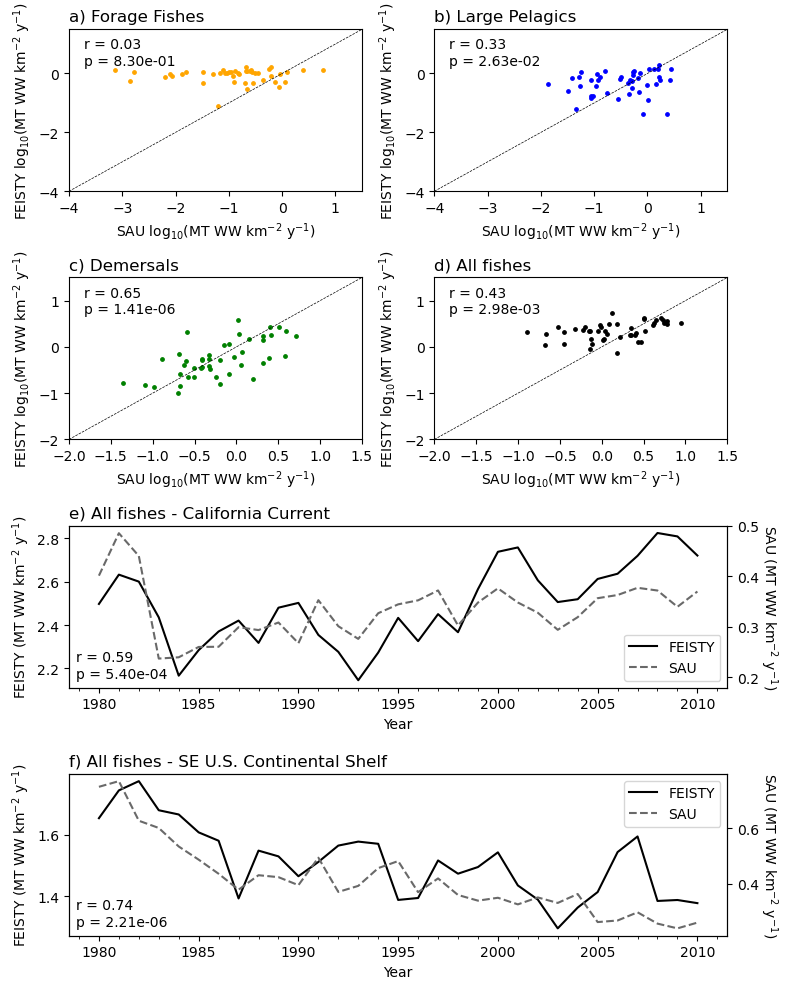

In [17]:
lme_range = keep_lmes
year_range = np.arange(1980, 2011)

fig = plt.figure(figsize=(8,10))

gs = fig.add_gridspec(4, 2)

ax1 = fig.add_subplot(gs[0, 0])

ax1.scatter(np.log10(true_catch_year_proc.FwCatch.sel(LMEID=lme_range)), 
            np.log10(modeled_catch_year_proc.FwCatch.sel(LMEID=lme_range)), color="orange", s=6)
ax1.axline((0,0), slope=1, color="k", linestyle="--", lw=0.5)
ax1.set_title("a) Forage Fishes", loc='left')
ax1.set_xlim(-4,1.5)
ax1.set_ylim(-4,1.5)

slope, intercept, r, p, se = scipy.stats.linregress(np.log10(true_catch_year_proc.FwCatch.sel(LMEID=lme_range)),
                                        np.log10(modeled_catch_year_proc.FwCatch.sel(LMEID=lme_range)))


ax1.text(.05, .95, "r = {:.2f}\np = {:.2e}".format(round(r, 2),round(p,3)), ha='left', va='top', transform=ax1.transAxes)


###########

ax2 = fig.add_subplot(gs[0, 1])

ax2.scatter(np.log10(true_catch_year_proc.PwCatch.sel(LMEID=lme_range)), 
            np.log10(modeled_catch_year_proc.PwCatch.sel(LMEID=lme_range)), color="blue", s=6)
ax2.axline((0,0), slope=1, color="k", linestyle="--", lw=0.5)
ax2.set_title("b) Large Pelagics", loc='left')
ax2.set_xlim(-4,1.5)
ax2.set_ylim(-4,1.5)

slope, intercept, r, p, se = scipy.stats.linregress(np.log10(true_catch_year_proc.PwCatch.sel(LMEID=lme_range)),
                                        np.log10(modeled_catch_year_proc.PwCatch.sel(LMEID=lme_range)))

ax2.text(.05, .95, "r = {:.2f}\np = {:.2e}".format(round(r, 2),round(p,4)), ha='left', va='top', transform=ax2.transAxes)

###########


ax3 = fig.add_subplot(gs[1, 0])

ax3.scatter(np.log10(true_catch_year_proc.DwCatch.sel(LMEID=lme_range)), 
            np.log10(modeled_catch_year_proc.DwCatch.sel(LMEID=lme_range)), color="green", s=6)
ax3.axline((0,0), slope=1, color="k", linestyle="--", lw=0.5)
ax3.set_title("c) Demersals", loc='left')
ax3.set_xlim(-2,1.5)
ax3.set_ylim(-2,1.5)

slope, intercept, r, p, se = scipy.stats.linregress(np.log10(true_catch_year_proc.DwCatch.sel(LMEID=lme_range)),
                                        np.log10(modeled_catch_year_proc.DwCatch.sel(LMEID=lme_range)))

ax3.text(.05, .95, "r = {:.2f}\np = {:.2e}".format(round(r, 2),round(p,8)), ha='left', va='top', transform=ax3.transAxes)

###########

ax4 = fig.add_subplot(gs[1, 1])

ax4.scatter(np.log10(true_catch_year_proc.FwCatch.sel(LMEID=lme_range) + 
                true_catch_year_proc.PwCatch.sel(LMEID=lme_range) + 
                true_catch_year_proc.DwCatch.sel(LMEID=lme_range)), 
                np.log10(modeled_catch_year_proc.FwCatch.sel(LMEID=lme_range) +
               modeled_catch_year_proc.PwCatch.sel(LMEID=lme_range) + 
               modeled_catch_year_proc.DwCatch.sel(LMEID=lme_range)), color="black", s=6)
ax4.axline((0,0), slope=1, color="k", linestyle="--", lw=0.5, label="Reference 1:1")
ax4.set_title("d) All fishes", loc='left')
ax4.set_xlim(-2,1.5)
ax4.set_ylim(-2,1.5)

slope, intercept, r, p, se = scipy.stats.linregress(np.log10(true_catch_year_proc.FwCatch.sel(LMEID=lme_range) + 
                true_catch_year_proc.PwCatch.sel(LMEID=lme_range) + 
                true_catch_year_proc.DwCatch.sel(LMEID=lme_range)),
                np.log10(modeled_catch_year_proc.FwCatch.sel(LMEID=lme_range) +
                modeled_catch_year_proc.PwCatch.sel(LMEID=lme_range) + 
                modeled_catch_year_proc.DwCatch.sel(LMEID=lme_range)))

ax4.text(.05, .95, "r = {:.2f}\np = {:.2e}".format(round(r, 2),round(p,5)), ha='left', va='top', transform=ax4.transAxes)


for i in [ax1, ax2, ax3, ax4]:
    i.set_xlabel("SAU log$_{10}$(MT WW km$^{-2}$ y$^{-1}$)")
    i.set_ylabel("FEISTY log$_{10}$(MT WW km$^{-2}$ y$^{-1}$)")

        
############################

bottom_ax = fig.add_subplot(gs[2, :])
        
true_catch_ts = (true_catch.FwCatch.sel(Year=year_range).sel(LMEID=3) + 
                true_catch.PwCatch.sel(Year=year_range).sel(LMEID=3) + 
                true_catch.DwCatch.sel(Year=year_range).sel(LMEID=3))

modeled_catch_ts = (modeled_catch.FwCatch.sel(Year=year_range).sel(LMEID=3) +
               modeled_catch.PwCatch.sel(Year=year_range).sel(LMEID=3) + 
               modeled_catch.DwCatch.sel(Year=year_range).sel(LMEID=3))

bottom_ax2 = bottom_ax.twinx()

l1 = bottom_ax.plot(year_range, modeled_catch_ts, label="FEISTY", color="black")
l2 = bottom_ax2.plot(year_range, true_catch_ts, "--", label="SAU", color="dimgrey")

bottom_ax2.set_title("e) All fishes - California Current", loc="left")


bottom_ax.set_xlabel("Year")
bottom_ax.set_ylabel("FEISTY (MT WW km$^{-2}$ y$^{-1}$)")
bottom_ax2.set_ylabel("SAU (MT WW km$^{-2}$ y$^{-1}$)", labelpad=15, rotation=-90)

bottom_ax2.set_ylim(0.18,0.5)

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
bottom_ax.xaxis.set_minor_locator(MultipleLocator(1))
        
fig.tight_layout()


bottom_ax2.legend( handles=l1+l2, loc="lower right")

slope, intercept, r, p, se = scipy.stats.linregress(true_catch_ts, modeled_catch_ts)

bottom_ax.text(.01, .23, "r = {:.2f}\np = {:.2e}".format(round(r, 2),round(p,6)), ha='left', va='top', transform=bottom_ax.transAxes)

##############

        
bottom_ax3 = fig.add_subplot(gs[3, :])
        
true_catch_ts = (true_catch.FwCatch.sel(Year=year_range).sel(LMEID=6) + 
                true_catch.PwCatch.sel(Year=year_range).sel(LMEID=6) + 
                true_catch.DwCatch.sel(Year=year_range).sel(LMEID=6))

modeled_catch_ts = (modeled_catch.FwCatch.sel(Year=year_range).sel(LMEID=6) +
               modeled_catch.PwCatch.sel(Year=year_range).sel(LMEID=6) + 
               modeled_catch.DwCatch.sel(Year=year_range).sel(LMEID=6))

bottom_ax4 = bottom_ax3.twinx()

l3 = bottom_ax3.plot(year_range, modeled_catch_ts, label="FEISTY", color="black")
l4 = bottom_ax4.plot(year_range, true_catch_ts, "--", label="SAU", color="dimgrey")

bottom_ax3.set_title("f) All fishes - SE U.S. Continental Shelf", loc="left")


bottom_ax3.set_xlabel("Year")
bottom_ax3.set_ylabel("FEISTY (MT WW km$^{-2}$ y$^{-1}$)")
bottom_ax4.set_ylabel("SAU (MT WW km$^{-2}$ y$^{-1}$)", labelpad=15, rotation=-90)


from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
bottom_ax3.xaxis.set_minor_locator(MultipleLocator(1))
        
fig.tight_layout()


bottom_ax3.legend( handles=l3+l4, loc="upper right")

slope, intercept, r, p, se = scipy.stats.linregress(true_catch_ts, modeled_catch_ts)

bottom_ax3.text(.01, .23, "r = {:.2f}\np = {:.2e}".format(round(r, 2),round(p,8)), ha='left', va='top', transform=bottom_ax3.transAxes)

##############


fig.tight_layout()

plt.savefig("FigS4_FEISTY_validation_x1.png", dpi=300)

plt.show()